# Imports 

In [332]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

# Helper Functions

In [335]:
def get_data(num_points=100, shape='8'):

    if shape == '8':
        # Generate a dataset in the shape of "8"
        t = np.linspace(0, 2 * np.pi, num_points)
        x = np.sin(t)
        y = np.sin(t) * np.cos(t)

        # Add some noise to the data
        noise = 0.01 * np.random.randn(len(t))
        x += noise
        y += noise
        
    elif shape=='flower':
        
        # Create a flower-like dataset
        theta = np.linspace(0, 2*np.pi, num_points)
        r = np.sin(5*theta) + 0.2 * np.random.rand(len(theta))

        x = r * np.cos(theta)
        y = r * np.sin(theta)
    
    elif shape=='parabola':
        
        # Generate a dataset in the shape of "8"
        t = np.linspace(-1, 1, num_points)
        x = t
        y = t**2

        # Add some noise to the data
        noise = 0.01 * np.random.randn(len(t))
        x += noise
        y += noise
        


        
        
    # Convert the NumPy arrays to Torch tensors and stack them horizontally
    data = torch.tensor([x, y], dtype=torch.float32)
    
    return data.T


In [336]:
def visualise_mainfold(data):
    
    # Plot the dataset
    x = data[:, 0]
    y = data[:, 1]
    plt.grid()
    plt.scatter(x, y, marker='.', c='crimson')
    plt.title('2D Dataset Mainfold Visualised')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')  
    plt.show()

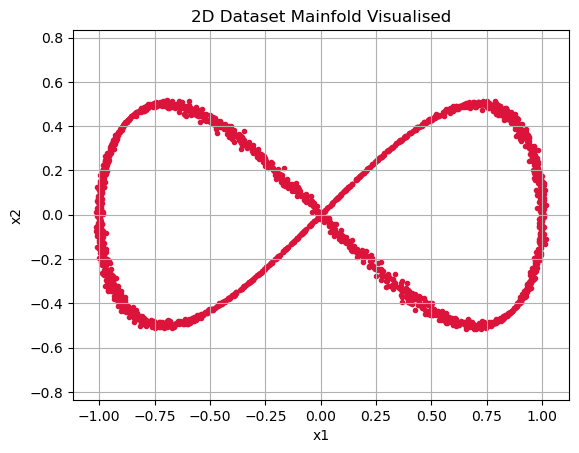

In [337]:
data = get_data(num_points=2000, shape='8')
visualise_mainfold(data)

In [338]:
def generate_new_sample(alpha, alpha_bar, sigma, net, T=100, num_samples=50, input_dim=2):

    # Store all the samples in the difussion process in X
    X = torch.zeros((T+1, num_samples, input_dim)) 
    # # Last step sample X[T] is pure gaussian noise
    X[T] = torch.randn((num_samples, input_dim)) 
    # Reverse Process 
    for t in range(T, 0, -1):

        if t!=1:
            Z = torch.randn((num_samples, input_dim))
        else:
            Z = torch.zeros((num_samples, input_dim))
        
        T_vec =  torch.full((num_samples, 1), t)
        X[t-1] = X[t] - ((1-alpha[t])/torch.sqrt(1-alpha_bar[t]))*net(X[t], T_vec)
        X[t-1] = (1/torch.sqrt(alpha[t]))*X[t-1] + sigma[t]*Z
    
    return X

## Neural net definition

In [323]:
class EpsNet(nn.Module):
    def __init__(self,input_dim=5, T=1000):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=16)
        self.layer_2 = nn.Linear(16,64)
        self.layer_3 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.T = T
        
    def forward(self, X, t):
        
        t = torch.cat(((t/self.T)**0.5,t/self.T,(t/self.T)**2),-1)
        X = torch.cat((X,t), -1)
        
        out = self.layer_1(X)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out)
        #out = 3*self.relu(out)
        
        return out

# Model Definition and Parameters

In [339]:
T = 4000  # T is number of diffusion steps
input_dim = data.shape[1]# the dimeinsions of input samples
batch_size = 100
num_epochs = 10000
num_batches = len(data)//batch_size

In [340]:
model = EpsNet(input_dim=5, T=T)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [341]:
beta = torch.linspace(0.0,.999,T+1)
alpha = 1-beta
sigma = torch.sqrt(beta)
alpha_bar = torch.cumprod(alpha, dim=0) # cumlative product

# Training

In [342]:
eloss_list = []

In [343]:
# sample batch 
for epoch in range(1,num_epochs+1):
    running_loss = 0
    for batch in range(1,num_batches+1):
        random_indices = np.random.choice(len(data), batch_size, replace=False)
        X = data[random_indices]

        t = torch.randint(1,T+1,size = [batch_size,1])

        noise = torch.randn((batch_size,input_dim))

        X_t = torch.sqrt(alpha_bar[t])*X + torch.sqrt(1-alpha_bar[t])*noise

        # 1. forward pass
        y_pred = model(X_t, t)
        # 2. loss calculation
        loss = criterion(y_pred,noise)
        # 3. Clear up the gradients
        optimizer.zero_grad()
        # 4. back propagations
        loss.backward()
        # 5. gradient descents
        optimizer.step()
    
        running_loss += loss.item()*len(X)
    
    epoch_loss = running_loss/len(data)
    eloss_list.append(epoch_loss)
    
    if epoch%10==0:
        print(f"epoch{epoch}-----{epoch_loss}")
        eloss_list.append(loss.item())

epoch10-----0.021190141746774315
epoch20-----0.011100265488494188
epoch30-----0.018352806038456036
epoch40-----0.01495460297446698
epoch50-----0.01567767553497106
epoch60-----0.01091794739186298
epoch70-----0.01622112179757096
epoch80-----0.009777085739187896
epoch90-----0.01456622437108308
epoch100-----0.020800399233121426
epoch110-----0.01572971560526639
epoch120-----0.013509516834164969
epoch130-----0.012846283127146307
epoch140-----0.01596205311070662
epoch150-----0.010483631430543029
epoch160-----0.017036064718558917
epoch170-----0.011203352134907618
epoch180-----0.010681146998831537
epoch190-----0.014231236692285164
epoch200-----0.014284519483044277
epoch210-----0.013418082805583254
epoch220-----0.015947515916195698
epoch230-----0.010576775146182627
epoch240-----0.01569246324361302
epoch250-----0.011263159970985726
epoch260-----0.01723821882624179
epoch270-----0.00884345716331154
epoch280-----0.015039090483332984
epoch290-----0.011822972301160917
epoch300-----0.012825602023804094

epoch2410-----0.016036467085359617
epoch2420-----0.014577421118156053
epoch2430-----0.015326833794824779
epoch2440-----0.014779927443305496
epoch2450-----0.012754398543620482
epoch2460-----0.010516744770575315
epoch2470-----0.010558631992898882
epoch2480-----0.010711116649326868
epoch2490-----0.011893889779457822
epoch2500-----0.014424153364961967
epoch2510-----0.018050743214553223
epoch2520-----0.02070731983403675
epoch2530-----0.008878618729067967
epoch2540-----0.012612838065251708
epoch2550-----0.015573218144709244
epoch2560-----0.011650374780583662
epoch2570-----0.012509789999603527
epoch2580-----0.01127450646017678
epoch2590-----0.014057906719972379
epoch2600-----0.008147808224020992
epoch2610-----0.012334510115033481
epoch2620-----0.015658717090263962
epoch2630-----0.01627000145963393
epoch2640-----0.015041904308600352
epoch2650-----0.012810480526968603
epoch2660-----0.013362460673670284
epoch2670-----0.01349551276944112
epoch2680-----0.014727983705233783
epoch2690-----0.00979295

epoch4770-----0.0054985438058793076
epoch4780-----0.012776065120124257
epoch4790-----0.010933855222538114
epoch4800-----0.010032655236136634
epoch4810-----0.010078826299286447
epoch4820-----0.011758378412923775
epoch4830-----0.009421751549234613
epoch4840-----0.011969544072053395
epoch4850-----0.01815995718643535
epoch4860-----0.013625331805087626
epoch4870-----0.011069216087344102
epoch4880-----0.013713389484291839
epoch4890-----0.019205715708085335
epoch4900-----0.013221460790373386
epoch4910-----0.014564806429552846
epoch4920-----0.013261968857841566
epoch4930-----0.012897444322152295
epoch4940-----0.010017191106453539
epoch4950-----0.008501046758465237
epoch4960-----0.010111498716287314
epoch4970-----0.010464299713203219
epoch4980-----0.011426513380138203
epoch4990-----0.011559344857232645
epoch5000-----0.010833691630978137
epoch5010-----0.012336992996279151
epoch5020-----0.010539921838790179
epoch5030-----0.01323930147336796
epoch5040-----0.016889681306201963
epoch5050-----0.01127

epoch7130-----0.01024320640062797
epoch7140-----0.007998628774657845
epoch7150-----0.012763960845768451
epoch7160-----0.009208906439016572
epoch7170-----0.012529363029170782
epoch7180-----0.013422526279464364
epoch7190-----0.016712649341206996
epoch7200-----0.007585140813898761
epoch7210-----0.014350535056291847
epoch7220-----0.017643681640038267
epoch7230-----0.011403650027932598
epoch7240-----0.010577698744600638
epoch7250-----0.011782577013946138
epoch7260-----0.016813654810539445
epoch7270-----0.012012621911708266
epoch7280-----0.011727015738142655
epoch7290-----0.011078454743255861
epoch7300-----0.007970034902973567
epoch7310-----0.009460517311526927
epoch7320-----0.011654792915214785
epoch7330-----0.010417880426393822
epoch7340-----0.012513474399747792
epoch7350-----0.010432023993053008
epoch7360-----0.011760458396747709
epoch7370-----0.010301433491986246
epoch7380-----0.0072280396183487024
epoch7390-----0.009623564479261404
epoch7400-----0.009556666517164558
epoch7410-----0.0083

epoch9490-----0.009769421696546488
epoch9500-----0.014795917666924651
epoch9510-----0.012634888901084195
epoch9520-----0.013076963339699432
epoch9530-----0.011054110820987261
epoch9540-----0.009618450848211068
epoch9550-----0.010749840580683668
epoch9560-----0.009881688060704618
epoch9570-----0.011943170276936144
epoch9580-----0.011494187523203437
epoch9590-----0.011263153528852854
epoch9600-----0.017109098130458734
epoch9610-----0.009136622067308054
epoch9620-----0.014474523661192507
epoch9630-----0.009957905049668625
epoch9640-----0.012671140965539961
epoch9650-----0.009678927456843667
epoch9660-----0.013605967129115016
epoch9670-----0.007891681761793733
epoch9680-----0.01897397288994398
epoch9690-----0.00857347782002762
epoch9700-----0.009076834726147353
epoch9710-----0.010661642155901064
epoch9720-----0.011858750502869952
epoch9730-----0.013885406942426926
epoch9740-----0.012841905519599095
epoch9750-----0.012967009135172703
epoch9760-----0.008415031651384196
epoch9770-----0.017227

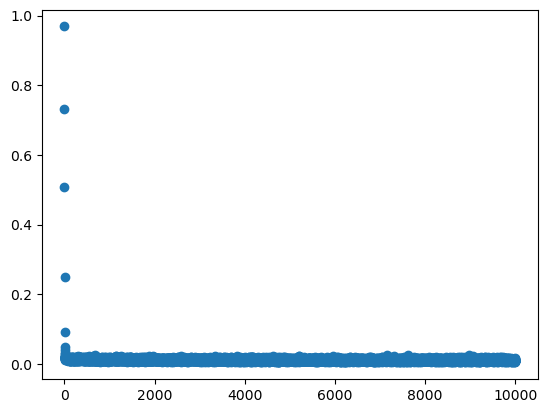

In [344]:
x = np.arange(len(eloss_list))+1

y = np.array(eloss_list)
plt.scatter(x, y)
plt.show()

In [345]:
X_gen = generate_new_sample(alpha=alpha, alpha_bar=alpha_bar, sigma=sigma, 
               net=model, T=T, num_samples=400, input_dim=2)

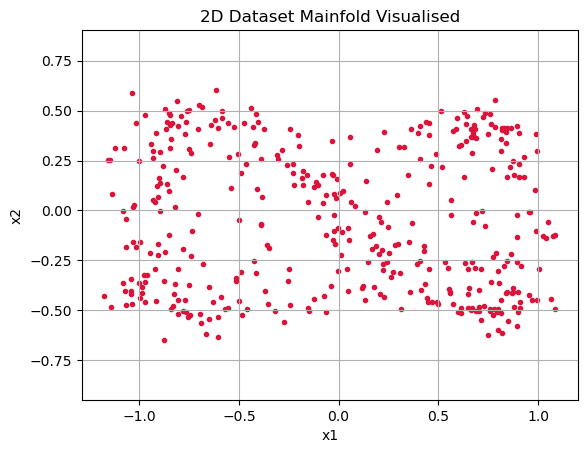

In [346]:
visualise_mainfold(X_gen[0].detach())